[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/gist/yhwang17/d58485db8dd6b7e2098825a7c9d43fad/dppm_remd_sciml.ipynb)

#**Denoising Diffusion Probabilistic Model for Replica exchange MD simulation, in Pytorch**

Implementation of <a href="https://arxiv.org/abs/2006.11239">Denoising Diffusion Probabilistic Model</a> for data from replica exchange MD. This implementation was transcribed from the  Tensorflow version <a href="https://github.com/hojonathanho/diffusion">Ho, J., Jain, A. and Abbeel, P., 2020. arXiv:2006.11239.</a> and a modified Pytorch version <a href="https://github.com/lucidrains/denoising-diffusion-pytorch">here</a>. 

This demon mainly consists of three parts:


*   Dataset preparation
*   Training
*   Generate samples



In [6]:
!git clone https://github.com/tiwarylab/DDPM_REMD.git

fatal: destination path 'DDPM_REMD' already exists and is not an empty directory.


In [11]:
!cd DDPM_REMD

/content/DDPM_REMD


In [2]:
!pip3 install einops
!pip3 install pillow
!pip3 install tqdm

In [3]:
from torch.utils import data
import numpy as np
import matplotlib.pyplot as plt

## Replica exchange molecular dynamics simulation（REMD）
In REMD, replicas with different temperatures are run in parallel. Attempts to exchange the configurations between replicas are made every certain simulation steps.

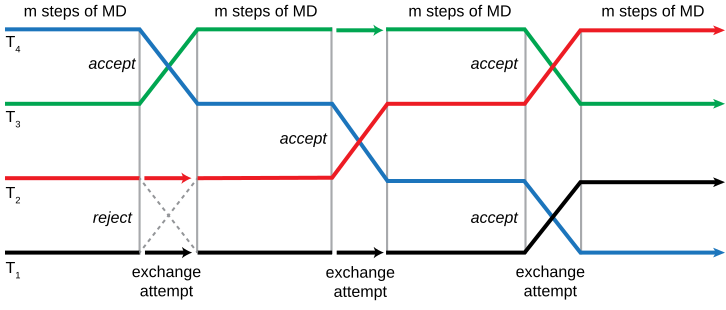

##Denoising Diffusion Probabilistic Model (DDPM)
DDPM learns to reverse a gradual, multi-step noising process that starts with samples generated from the distribution $p(\mathbf{s})$, which we do not have direct access to, and diffuses to the simpler distribution $P_{simple}(\mathbf{s})$ that is easy-to-sample.
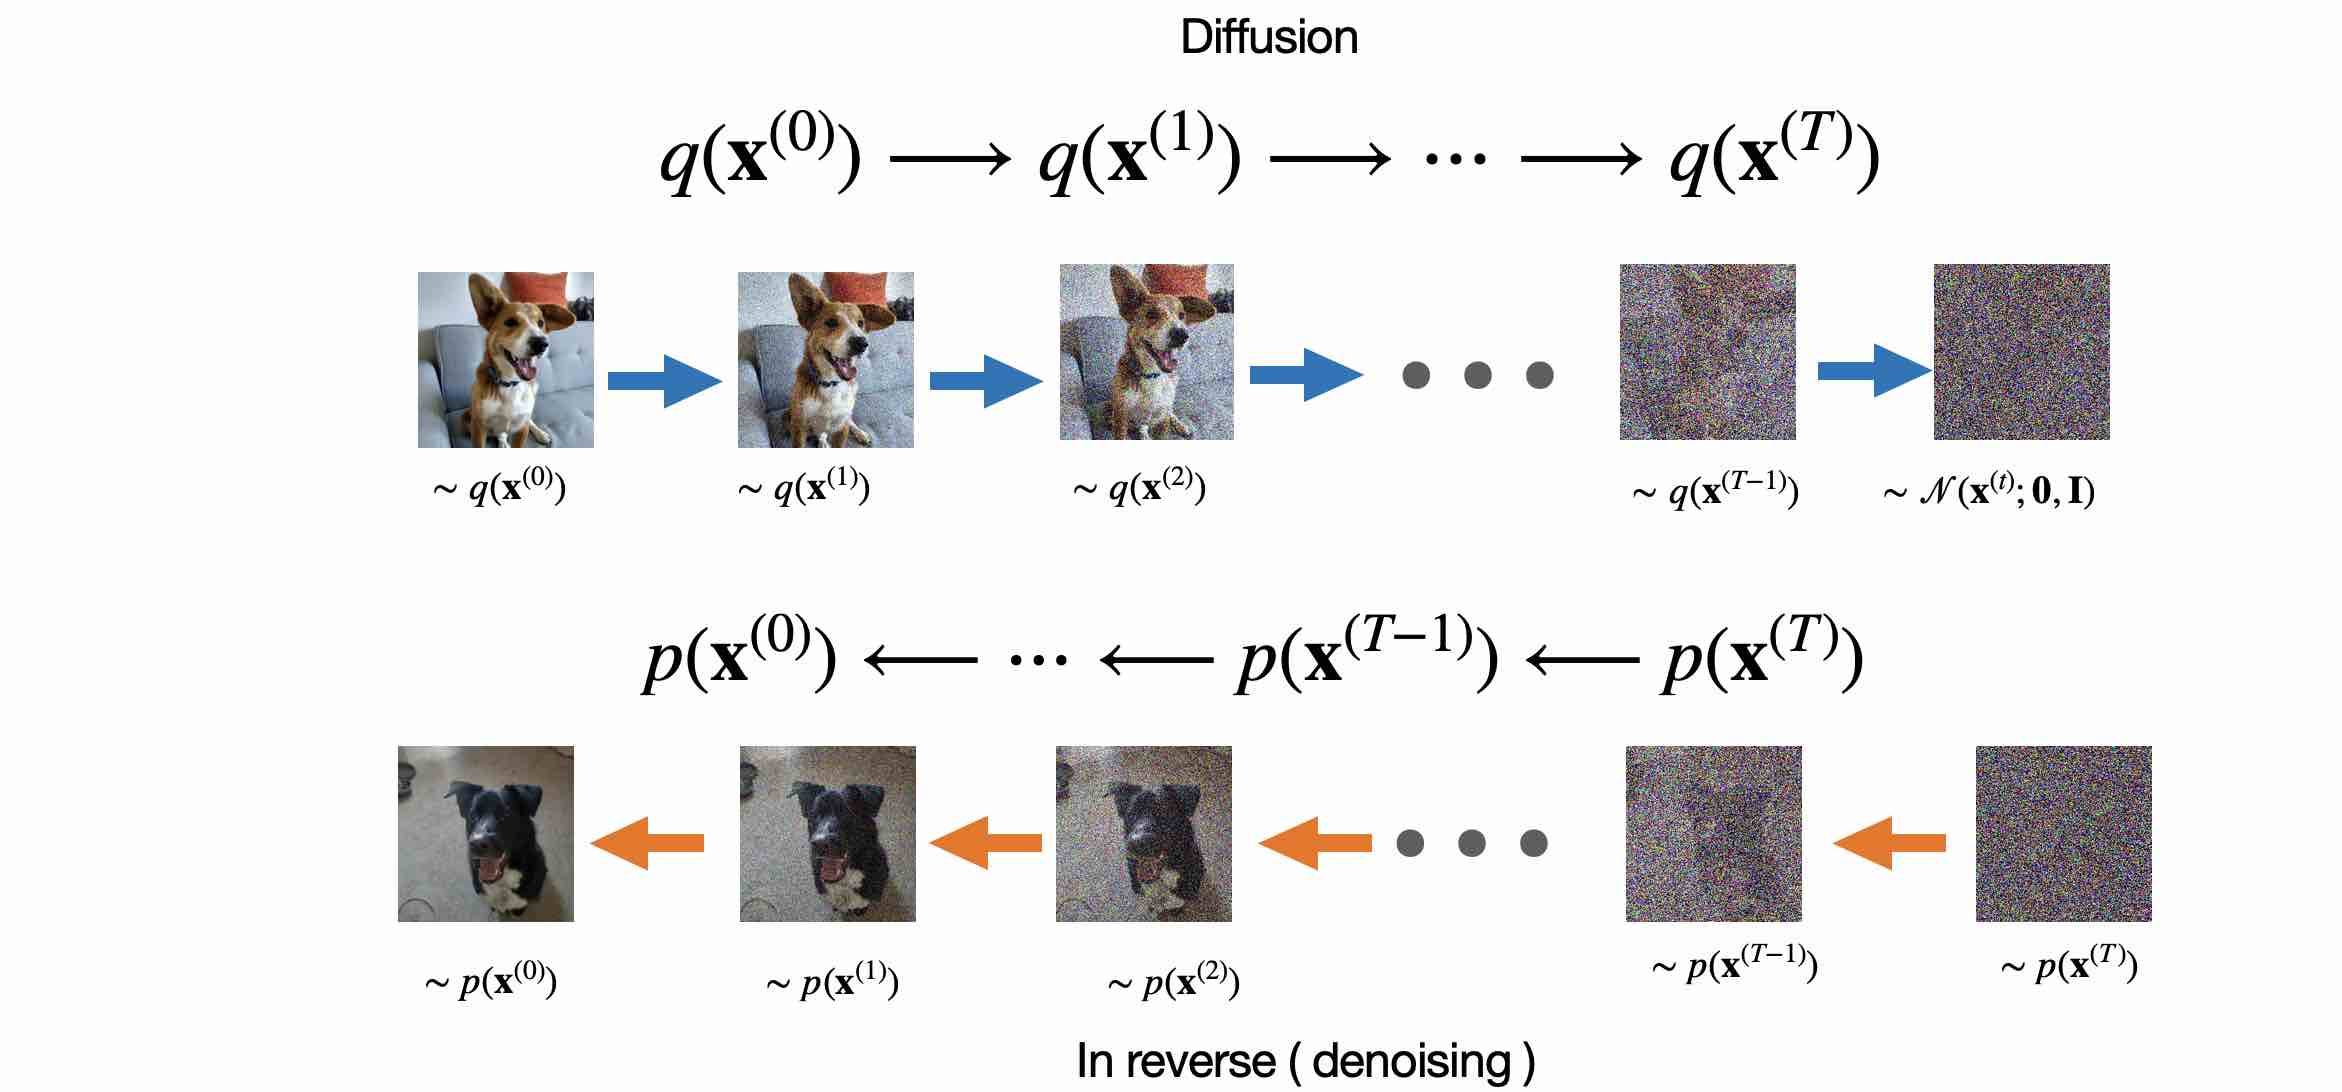


#**Dataset preparation**
Example: AIB9
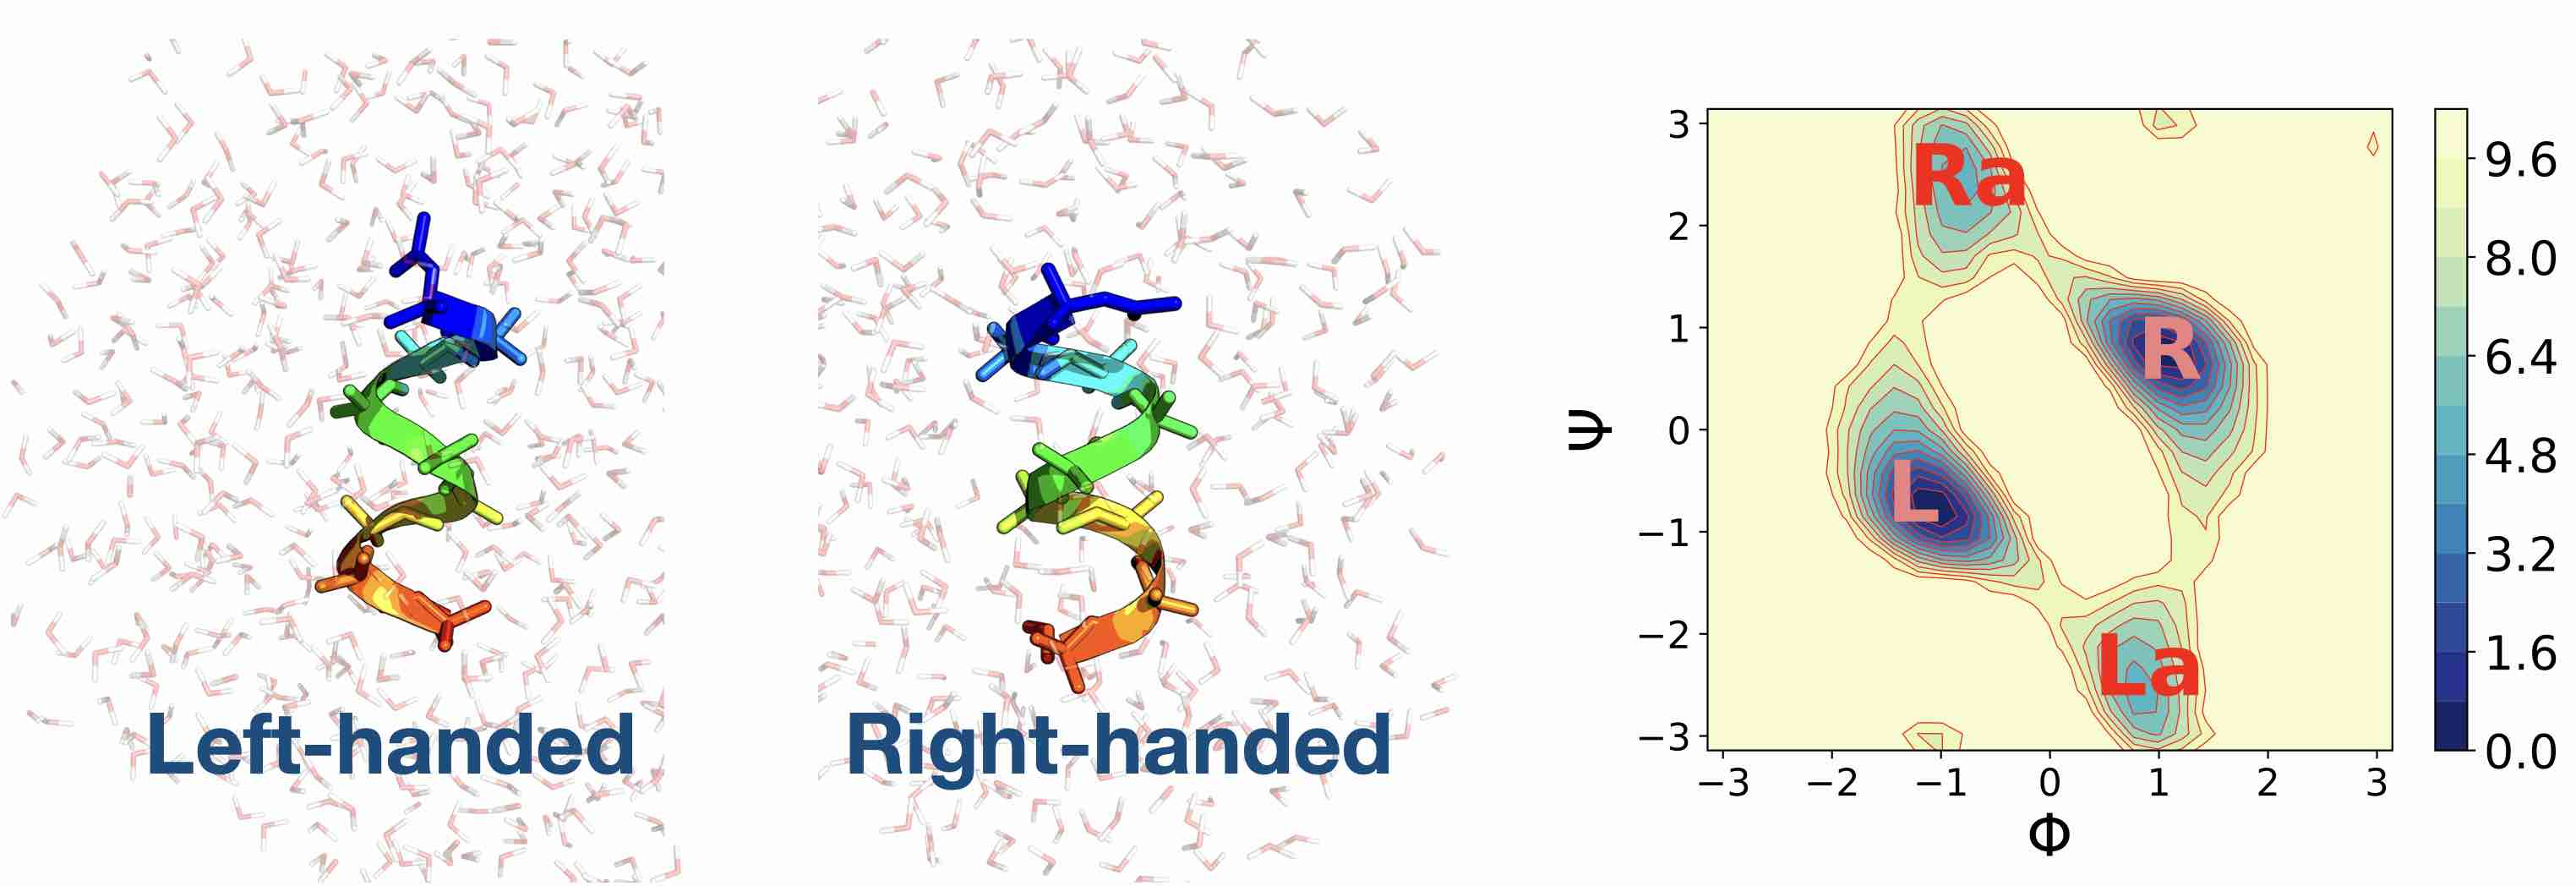

###Task: 
####learn a generator to generate samples from $P(\Phi_1, \Psi_1, \Phi_2, \Psi_2, \cdots \Phi_9, \Psi_9|T)$

In [12]:
training_data = np.load('traj_AIB9/AIB9_REMD_T_full_100000ps_2.0ps_traj.npy') # load the dataset
print(np.shape(training_data))

(500000, 19)


The training data set should be a 2-D array of shape $(n, N_{op}+1)$

$n$ is the number of data points 

$N_{op}$ is the number of order parameters

The first column of the 2-D array should be the instantaneous temperature that derived from its instantaneous kinetic energy.

temperature  | $\Phi_1$ | $\Psi_1$ | $\Phi_2$ | $\Psi_2$  | $\cdots$ | $\Phi_9$ | $\Psi_9$ 
-------------------|------------------|------------------ |------------------|------------------ |------------------|------------------ |------------------
396.1   | 0.76  | -2.19     | -1.29 | -0.76  |  $\cdots$ | -1.39 | -0.66
401.6     |  0.46  | -2.106 | -1.21 | -0.63   |  $\cdots$ | -1.10| -0.85
$\cdots$|$\cdots$|$\cdots$ |$\cdots$|$\cdots$ |$\cdots$|$\cdots$ |$\cdots$

Text(0, 0.5, 'P(T)')

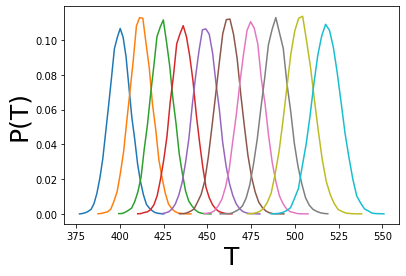

In [13]:
#plot the distribution of instantaneous temperature of each replica
T = training_data[:,0]
n_sample_replica = 50000
n_replica = 10
for j in range(n_replica):
  T = training_data[j*n_sample_replica: (j+1)*n_sample_replica,0]
  his, edges = np.histogram(T, bins= 30)
  his = his/np.sum(his)
  T_x = (edges[1:] + edges[:-1])/2
  plt.plot(T_x, his)
plt.xlabel('T', fontsize = 25)
plt.ylabel('P(T)', fontsize = 25)

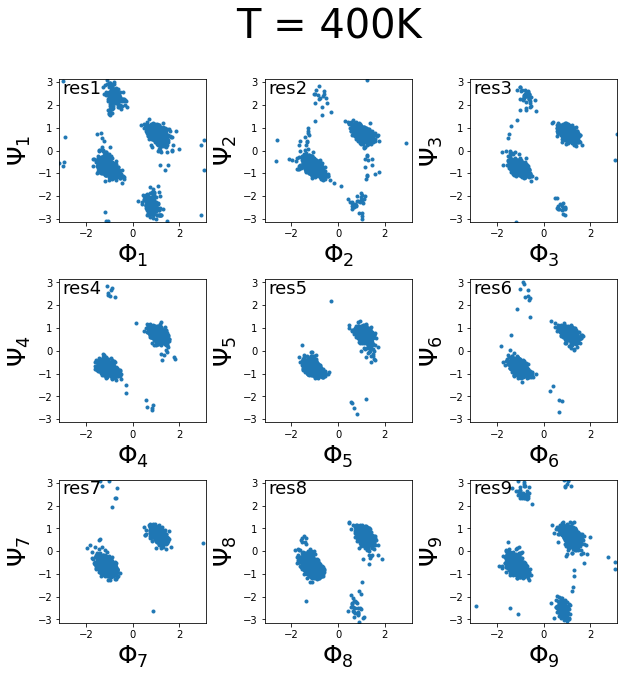

In [16]:
# plt samples from replica with T=400
fig = plt.figure(figsize=(10, 10),frameon=False)
fig.subplots_adjust(hspace=0.4, wspace=0.4)
fig.suptitle('T = 400K', fontsize=40)
for i in range(1, 10):
    ax = fig.add_subplot(3, 3, i)
    ax.plot(training_data[:n_sample_replica:25, i*2-1], training_data[:n_sample_replica:25, i*2],'.')    
    ax.text(-3, 2.5,  f'res{i}', fontsize = 18)
    ax.set_xlim([-np.pi, np.pi])
    ax.set_ylim([-np.pi, np.pi])
    ax.set_xlabel(r'$\Phi_%i$'%i, fontsize = 25)
    ax.set_ylabel(r'$\Psi_%i$'%i, fontsize = 25)

#**Training**
###network archetecture
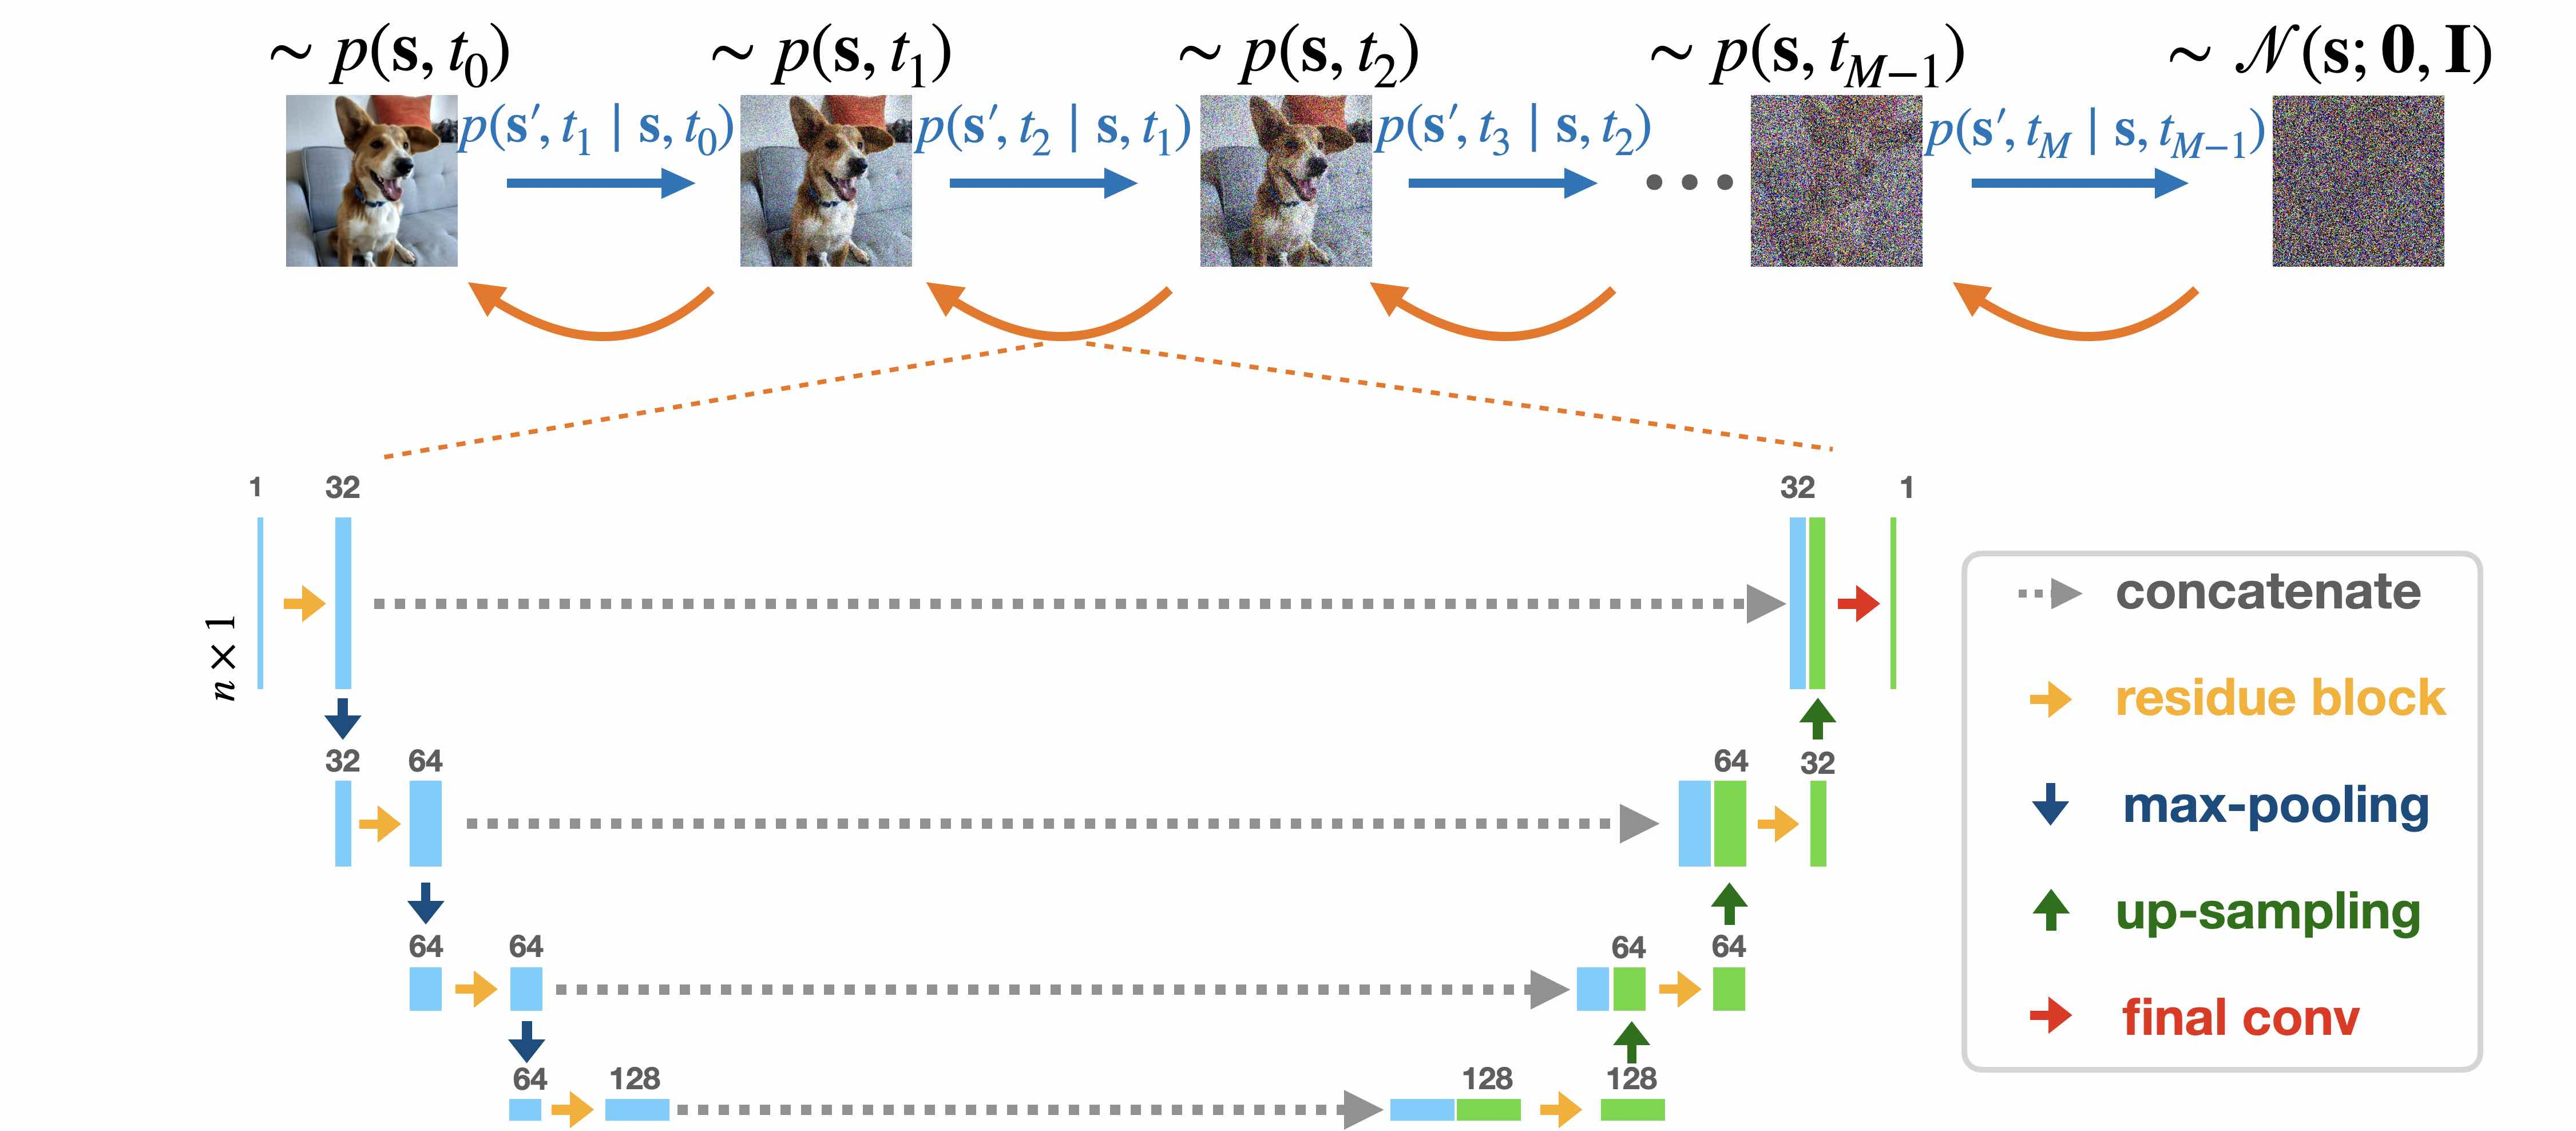

In [42]:
from denoising_diffusion_pytorch import Unet, GaussianDiffusion, Trainer, Dataset_traj, cycle, num_to_groups
import torch
from torch import nn 

device = torch.device("cuda")

# define the U-net structure
model = Unet(
    dim = 32,                   
    dim_mults = (1, 2, 2, 4 ),   
    groups = 8 
).to(device) 
model = nn.DataParallel(model)
model.to(device)

# define diffusion model
op_num = 18  
konw_op_num = 0
diffusion = GaussianDiffusion(
    model,                        # U-net model
    timesteps = 1000,             # number of diffusion steps
    unmask_number=konw_op_num+1,  # the dimension of x2 in P(x1|x2)
    loss_type = 'l2'              # L1 or L2
).to(device)

#set training parameters
trainer = Trainer(
    diffusion,                                   # diffusion model
    folder = 'traj_AIB9',                        # folder of trajectories
    system = 'AIB9_REMD_T_full_100000ps_2.0ps',  # name of the trajectory, the file {system}_traj.npy will be used as the training set
    train_batch_size = 128,                      # training batch size
    train_lr = 1e-5,                             # learning rate
    train_num_steps = 2000000,                   # total training steps
    gradient_accumulate_every = 1,               # gradient accumulation steps
    ema_decay = 0.995,                           # exponential moving average decay
    op_number = op_num,
    fp16 = False                                 # turn on mixed precision training with apex
)

# load trained model
model_id = 35     
trainer.load(model_id) 
# start training
#trainer.train()

#**Generate samples**

To generate samples from distribtuion $P(x_1 |x_2)$, we need to provide samples about the conditional part $x_2$. 

In this example, it is relatively simple as we only need to privde the information about the temperature. 

In [29]:
#prepare a dataloader to give samples from the conditional part of the distribution
batch_size = 1280  #the number of samples generated in each batch
sample_ds = Dataset_traj('traj_AIB9', 'sample_T') 
sample_ds.max_data = trainer.ds.max_data
sample_ds.min_data = trainer.ds.min_data        #To ensure that the sample data is scaled in the same way as the training data
sample_dl = cycle(data.DataLoader(sample_ds, batch_size = batch_size, shuffle=True, pin_memory=True)) 

T_sample = np.load('traj_AIB9/sample_T_traj.npy')
print(T_sample)

[[400.]
 [400.]
 [400.]
 ...
 [400.]
 [400.]
 [400.]]


In [40]:
num_sample = 2000 #total number of samples
model_id = 30
trainer.load(model_id) 

batches = num_to_groups(num_sample, batch_size)
all_ops_list = list(map(lambda n: trainer.ema_model.sample(trainer.op_number, batch_size=n, samples = next(sample_dl).cuda()[:n, :]), batches))
all_ops = torch.cat(all_ops_list, dim=0).cpu()
all_ops = trainer.rescale_sample_back(all_ops)
np.save(str(trainer.RESULTS_FOLDER / f'samples-{model_id}'), all_ops.numpy())
print(str(trainer.RESULTS_FOLDER / f'samples-{model_id}.npy'))

sampling loop time step: 100%|██████████| 1000/1000 [00:42<00:00, 23.64it/s]

results/AIB9_REMD_T_full_100000ps_2.0ps/32-1-2-2-4-b128/given_0_op/samples-30.npy


#**Result Analysis**

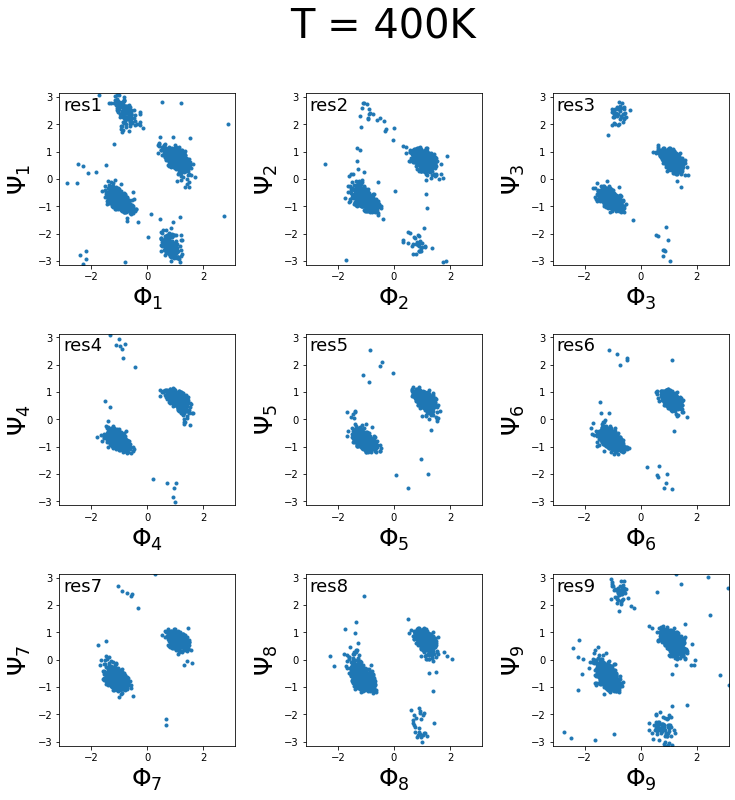

In [41]:
# plt samples generated from the model with T=400
samples = np.load('results/AIB9_REMD_T_full_100000ps_2.0ps/32-1-2-2-4-b128/given_0_op/samples-35.npy')
fig = plt.figure(figsize=(12, 12),frameon=False)
fig.subplots_adjust(hspace=0.4, wspace=0.4)
fig.suptitle('T = 400K', fontsize=40)
for i in range(1, 10):
    ax = fig.add_subplot(3, 3, i)
    ax.plot(samples[:,0, i*2-1], samples[:,0, i*2],'.')    
    ax.text(-3, 2.5,  f'res{i}', fontsize = 18)
    ax.set_xlim([-np.pi, np.pi])
    ax.set_ylim([-np.pi, np.pi])
    ax.set_xlabel(r'$\Phi_%i$'%i, fontsize = 25)
    ax.set_ylabel(r'$\Psi_%i$'%i, fontsize = 25)